# Load the libraries

In [ ]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn import mixture

# Load the dataset

In [20]:
df = pd.read_csv('Clustering_gmm.csv')
X = StandardScaler().fit_transform(df)

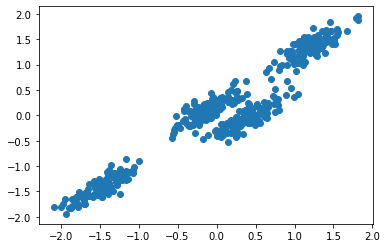

In [21]:
plt.scatter( X[:, 0],X[:, 1])
plt.show()

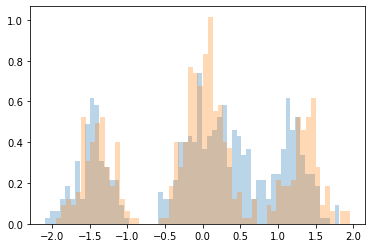

In [22]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=60)
plt.hist( np.array(X[:, 0]), **kwargs)
plt.hist(np.array(X[:, 1]), **kwargs)
plt.show()
#plt.hist(x3, **kwargs);
#plt.hist(X, stacked = True)

# Functions to plot the GMM results

In [27]:
def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    #splot.set_figheight(15)
    #splot.set_figwidth(15)
    #plt.figure(figsize=(5,5))
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

   
    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

In [28]:
def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Gaussian Mixture Model

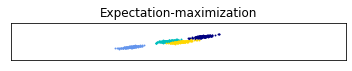

In [12]:
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

#### Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(
    n_components=4, covariance_type="full", max_iter=100
).fit(X)

plot_results(
    X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Expectation-maximization"
)

# GMM Implemenation

In [30]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

# Generate dataset using make_blob

In [31]:
from sklearn.datasets import make_blobs
import numpy as np
from scipy.stats import multivariate_normal


# 0. Create dataset
X,Y = make_blobs(cluster_std=1.5,random_state=20,n_samples=500,centers=3)

# Stratch dataset to get ellipsoid data
X = np.dot(X,np.random.RandomState(0).randn(2,2))

print(X.shape)

(500, 2)


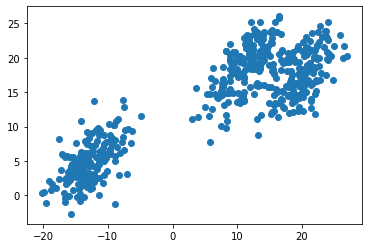

In [15]:
plt.scatter(X[:,0],X[:,1])

# Call the Gaussian Mixture Model Class

In [32]:
gmm = GMM(k=3, max_iter=10)
gmm.fit(X)
predicted_label = gmm.predict(X)

In [40]:
print(np.unique(predicted_label, return_counts = True))

(array([0, 1, 2], dtype=int64), array([188, 146, 166], dtype=int64))


In [41]:
df = pd.DataFrame(columns=['Weight','Height','Label'])
df['Feature1'] =X[:,0]
df['Feature2'] =X[:,1]
df['Label'] =predicted_label
df.shape

(500, 5)

<AxesSubplot:xlabel='Feature1', ylabel='Feature2'>

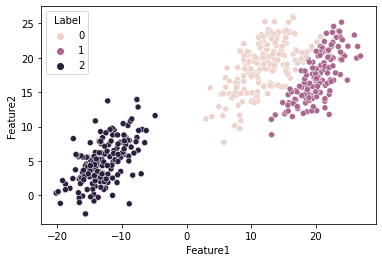

In [43]:
import seaborn as sns
sns.scatterplot(data =df,x='Feature1', y = 'Feature2',hue = 'Label')
#plt.scatter(X[:,0],X[:,1]s= predicted_label)